# Sentiment analysis of hotel reviews
Implementation of a data science process for predicting the sentiment contained in hotel reviews by building a binary classification model.

## Libraries

In [1]:
# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Preprocessing
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import ItalianStemmer
from nltk.corpus import stopwords as nltksw
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import emoji

# Classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import SVC

In [2]:
sns.set(style="whitegrid")

## Data exploration

In [3]:
df = pd.read_csv("data/dataset.csv")

### Structure

In [4]:
df

,text,class
0,Non è l'hotel più lussuoso in cui abbia mai so...,pos
1,Siamo stati qui per 1 notte prima della nostra...,pos
2,Hotel è ben posizionato per visitare Torino. A...,pos
3,All'arrivo la cordialità e disponibilità dello...,pos
4,Abbiamo soggiornato per due notti alla fine de...,pos
...,...,...
28749,L'hotel è vecchio ma caratteristico e devo dir...,neg
28750,Per essere un 4 stelle L la camera era un pò s...,pos
28751,Io e mia mamma (di età compresa tra 23 e 62) s...,pos
28752,Ci siamo sentiti accolti e coccolati fin dall'...,pos


### Missing values

In [5]:
n_null = df.isnull().sum().sum()
n_empty = df[df['text'] == ""].shape[0]

print(f"Missing values: {n_null}")
print(f"Number of empty reviews: {n_empty}")

Missing values: 0
Number of empty reviews: 0


### Class distribution

In [6]:
classes = set(df['class'])
classes

{'neg', 'pos'}

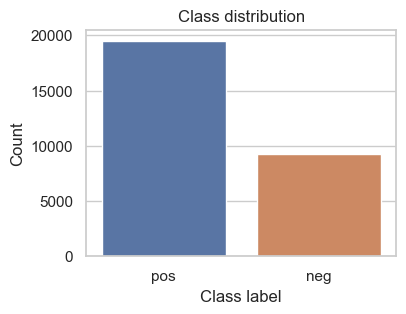

In [7]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=100)
ax = sns.countplot(df['class'])
ax.set_title("Class distribution")
plt.xlabel('Class label')
plt.ylabel('Count')
plt.show()

In [8]:
class_count = df['class'].value_counts()
class_count/class_count.sum()

pos    0.679279
neg    0.320721
Name: class, dtype: float64

### Length distribution

In [9]:
df['len'] = df['text'].str.len() # Add a column with review length to the dataframe

In [10]:
pct95 = int(np.ceil(df['len'].quantile(.95)))
pct50 = int(np.ceil(df['len'].quantile(.5)))

print(f"50th percentile: {pct50}, 95th percentile: {pct95}")

50th percentile: 515, 95th percentile: 1808


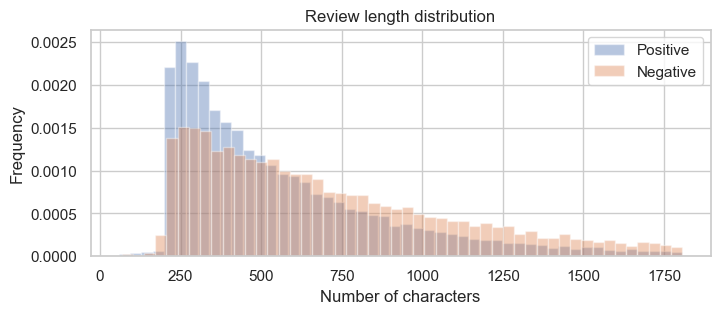

In [11]:
fig, ax = plt.subplots(figsize=(8, 3), dpi=100)
ax = sns.distplot(df['len'].loc[(df['class'] == 'pos') & (df['len'] < pct95)], bins=50, norm_hist=True, kde=False, label="Positive")
ax = sns.distplot(df['len'].loc[(df['class'] == 'neg') & (df['len'] < pct95)], bins=50, norm_hist=True, kde=False, label="Negative")
ax.set_title("Review length distribution")
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
ax.legend()
plt.show()

### Text contents

In [12]:
emoticon_chars = ["❤️", "😠", ":\)", ":\("]
count = 0
for c in emoticon_chars:
    c_count = df['text'].str.contains(c).sum()
    if c_count > 0:
        count += c_count

count

216

## Preprocessing

### Tokenization with stemmer

In [13]:
stemmer = ItalianStemmer()
stopwords = set(nltksw.words('italian')) - {"non"} | {"hotel"}

re_alphabet = re.compile('[^a-zA-Z]') # Matches any non-alphabet character
repeat_pattern = re.compile(r'^(\w)\1*|(\w)\2*$') # Matches repeating characters at the beginning and at the end of the string

# Tokens to save
punctuation = {'?', '!', '€', '$'}
emoticons = {':)', ':('}

def spell(s):
    count = 0
    pc = ''
    ns = ''
    
    # Correct characters repeating more than once at the beginning and the end of the string
    s = repeat_pattern.sub(r'\1\2', s)
    
    # Correct characters repeating more than twice
    for c in s:
        if pc == c:
            count += 1
        else:
            count = 1

        if count <= 2:
            ns += c

        pc = c
    
    return ns

def tokenizer(s):
    tokens = []
    
    for e in emoticons: # Handle text emoticons
        for _ in range(0, s.count(e)):
            tokens.append(e)
    
    for token in word_tokenize(s): # Tokenize the text and split off punctuation 
        token = re.split("(\W+|\d+)", token) # Split tokens on any non-alphanumeric character (e.g. apostrophes)
        
        for t in token:
            emojis = emoji.emoji_lis(t) # Handle Unicode emojis
            if len(emojis) > 0:
                for e in emojis:
                    tokens.append(emoji.demojize(e['emoji']))
                continue
            
            if t not in punctuation:
                t = re_alphabet.sub('', t) # Delete non-alphabetic characters
                
                if len(t) < 3 or len(t) > 20:
                    continue
            
            t = spell(t)
            
            if t in stopwords:
                continue
            
            t = stemmer.stem(t)
            tokens.append(t)
        
    return tokens

#### Tokenization test

In [14]:
test_string = "Ciao, questo è un testo di pppproooovaaaa! Proooova! €100 ❤️😠 :)) :( :)"
tokenizer(test_string)

[':)',
 ':)',
 ':(',
 'cia',
 'test',
 'proov',
 '!',
 'proov',
 '!',
 '€',
 ':red_heart:',
 ':angry_face:']

### Feature extraction

In [15]:
vectorizer_unbounded = TfidfVectorizer(input='content', tokenizer=tokenizer, ngram_range=(1,2))
X_unbounded = vectorizer_unbounded.fit_transform(df['text'])

In [16]:
vectorizer = TfidfVectorizer(input='content', tokenizer=tokenizer, min_df=2, max_features=15000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['text'])

### Feature exploration

In [17]:
X_unbounded # without max_features=15000

<28754x691029 sparse matrix of type '<class 'numpy.float64'>'
	with 3320701 stored elements in Compressed Sparse Row format>

In [18]:
X # with max_features=15000

<28754x15000 sparse matrix of type '<class 'numpy.float64'>'
	with 2090068 stored elements in Compressed Sparse Row format>

#### Wordclouds

In [19]:
def word_frequency(X, word_index):
    """Generate a dictionary that maps words to their frequency.
    
    :input X: sparse matrix with count values
    :word_index: dictionary (string to int) that maps words to column ids of X
    :return word_frequency: dictionary (string to float) that maps words to frequency
    """
    
    X_count = np.squeeze(np.asarray(X.sum(axis=0))) # array with shape (n_features,)
    X_total = X_count.sum()
    word_frequency = {k: X_count[v]/X_total for k,v in word_index.items()}
    
    return word_frequency

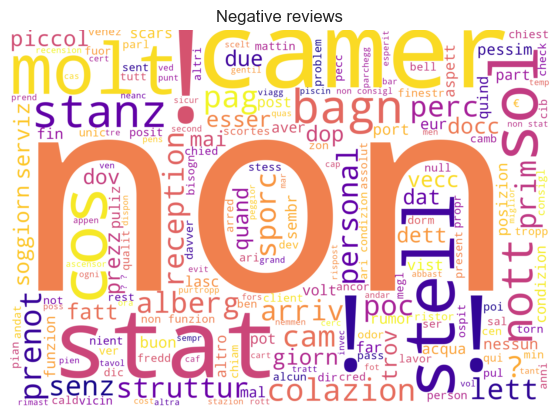

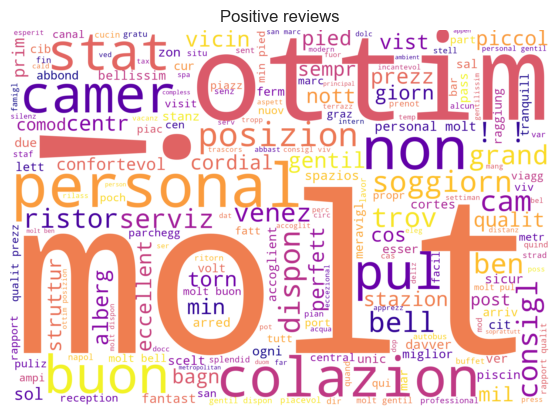

In [20]:
for c in classes:
    idx = df[df['class'] == c].index
    f = word_frequency(X[idx], vectorizer.vocabulary_)
    
    if c == "pos":
        title = "Positive reviews"
    elif c == "neg":
        title = "Negative reviews"
        
    wc = WordCloud(background_color='white', width=2000, height=1400, colormap="plasma")
    wordcloud = wc.generate_from_frequencies(f)

    fig, ax = plt.subplots(figsize=(7, 5), dpi=100)
    ax.set_title(title)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")

## Classification algorithm

### Train and test split

In [21]:
X_train, X_test, \
y_train, y_test = train_test_split(X, df['class'], test_size=0.2, stratify=df['class'], random_state=42)

In [22]:
print(f"Training samples: {X_train.shape[0]} Test samples: {X_test.shape[0]}")

Training samples: 23003 Test samples: 5751


In [23]:
def clf_metrics(y_test, y_pred):
    print(classification_report(y_test, y_pred, digits=4))
    
    fig = plt.figure(figsize=(3, 3), dpi=100)
    conf_mat = confusion_matrix(y_test, y_pred)
    label_names = ["neg", "pos"]
    conf_mat_df = pd.DataFrame(conf_mat, index = label_names, columns = label_names)
    conf_mat_df.index.name = 'Actual'
    conf_mat_df.columns.name = 'Predicted'
    sns.heatmap(conf_mat_df, annot=True, cmap='GnBu', 
    annot_kws={"size": 18}, fmt='g', cbar=False)

### Naive Bayes

#### Dataset normalization (min-max scaling)

In [24]:
scaler = MinMaxScaler(feature_range=(0,1))

X_train_scaled = scaler.fit_transform(X_train.todense())
X_test_scaled = scaler.transform(X_test.todense())

#### Multinomial naive Bayes (without cross validation; for preprocessing tuning)

              precision    recall  f1-score   support

         neg     0.9169    0.9452    0.9308      1844
         pos     0.9738    0.9596    0.9666      3907

    accuracy                         0.9550      5751
   macro avg     0.9453    0.9524    0.9487      5751
weighted avg     0.9555    0.9550    0.9551      5751



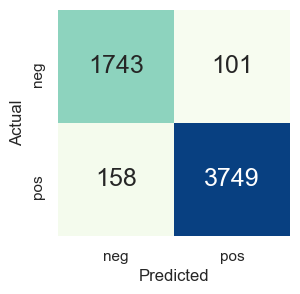

In [25]:
clf = MultinomialNB()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
clf_metrics(y_test, y_pred)

#### Multinomial naive Bayes

In [26]:
params = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

nb = MultinomialNB()
clf = GridSearchCV(nb, param_grid=params, scoring='f1_weighted', cv=5, n_jobs=3)
clf.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=3,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [27]:
clf.best_params_

{'alpha': 0.1}

              precision    recall  f1-score   support

         neg     0.9200    0.9420    0.9309      1844
         pos     0.9723    0.9614    0.9668      3907

    accuracy                         0.9551      5751
   macro avg     0.9462    0.9517    0.9488      5751
weighted avg     0.9555    0.9551    0.9553      5751



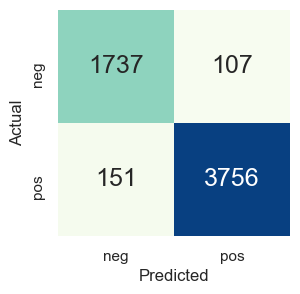

In [28]:
y_pred = clf.predict(X_test_scaled) # call predict on the estimator with the best found parameters
clf_metrics(y_test, y_pred)

#### Complement naive Bayes

In [29]:
params = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

nb = ComplementNB()
clf = GridSearchCV(nb, param_grid=params, scoring='f1_weighted', cv=5, n_jobs=3)
clf.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=ComplementNB(alpha=1.0, class_prior=None, fit_prior=True,
                                    norm=False),
             iid='deprecated', n_jobs=3,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [30]:
clf.best_params_

{'alpha': 0.1}

              precision    recall  f1-score   support

         neg     0.9109    0.9534    0.9316      1844
         pos     0.9775    0.9560    0.9666      3907

    accuracy                         0.9551      5751
   macro avg     0.9442    0.9547    0.9491      5751
weighted avg     0.9561    0.9551    0.9554      5751



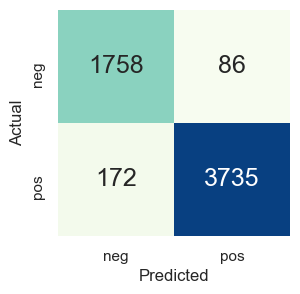

In [31]:
y_pred = clf.predict(X_test_scaled)
clf_metrics(y_test, y_pred)

### Support vector machine

In [32]:
params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svc = SVC(random_state=42)
clf = GridSearchCV(svc, param_grid=params, scoring='f1_weighted', cv=5, n_jobs=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=3,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [33]:
clf.best_params_

{'C': 1, 'kernel': 'linear'}

              precision    recall  f1-score   support

         neg     0.9496    0.9403    0.9450      1844
         pos     0.9720    0.9765    0.9742      3907

    accuracy                         0.9649      5751
   macro avg     0.9608    0.9584    0.9596      5751
weighted avg     0.9648    0.9649    0.9648      5751



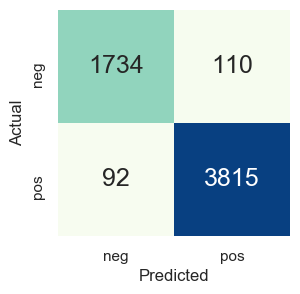

In [34]:
y_pred = clf.predict(X_test)
clf_metrics(y_test, y_pred)